In [11]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import scipy

In [1]:
def generate_city_grid(n, branch_prob, road_length):
    """
    Generate a city grid with main roads and branching side roads.

    Args:
        n (int): Size of the grid (n x n).
        branch_prob (float): Probability of branching from a road tile.
        road_length (int): Maximum length of each branching road.

    Returns:
        np.ndarray: A 2D grid representing the city layout.
        -1 represents road tiles.
         1 represents occupied spaces (houses).
    """
    grid = np.ones((n, n), dtype=int)

    # Select from a central half the "main" roads
    horizontal_road = random.randint(n // 4, 3 * n // 4)
    vertical_road = random.randint(n // 4, 3 * n // 4)
    
    # Set "main" roads
    grid[horizontal_road, :] = -1
    grid[:, vertical_road] = -1

    def grow_road(x, y, direction, length):
        for a in range(length):
            if 0 <= x < n and 0 <= y < n:
                grid[x, y] = -1
                # Chance to snake off in a random direction
                if random.random() < 0.3:
                    #Represents the directions, 0 being no change in that direction, 1 being to the right / down and -1 being to the left / up
                    direction = random.choice([(0, 1), (1, 0), (0, -1), (-1, 0)])
                    # Adds onto the road for both our x and y direcrtions
                x += direction[0]
                y += direction[1]
    
    # Generate branches along the primary roads with snaky paths
    for i in range(n):
        for j in range(n):
            # Find a tile with road on it and use our probability
            if grid[i, j] == -1 and random.random() < branch_prob:
                # 
                initial_direction = random.choice([(0, 1), (1, 0), (0, -1), (-1, 0)])  # Right, Down, Left, Up
                grow_road(i, j, initial_direction, road_length)
                
    for i in range(1, n - 1): # Use n-1 as receiving indexing error, possibly due to bounding
        for j in range(1, n - 1):
            if grid[i, j] == -1:
                # Check if all surrounding tiles are road
                # This is annoying as it can only get the 1 from the left to right and top to bottom first,
                # Then the others don't count as they have 1 house neighbour
                if (grid[i-1, j] == -1 and grid[i+1, j] == -1 and
                    grid[i, j-1] == -1 and grid[i, j+1] == -1):
                    grid[i, j] == 1  #Change out of road

    return grid

In [2]:
def initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho):
    """
    Initializes affluence and house grids based on the generated city grid.
    Houses receive random affluence levels, while roads remain at 0.
    """
    n, m = city_grid.shape
    noise = np.random.rand(n, m)
    affluence_grid = np.zeros((n, m), dtype=float)
    house_grid = np.zeros((n, m), dtype=float)
    politics_grid = np.zeros((n, m), dtype = float)
    continuous_political_grid = np.zeros((n, m), dtype = float)
    religion_grid = np.zeros((n, m), dtype = float)
    ethnicity_grid = np.zeros((n, m), dtype = float)
    for i in range(n):
        for j in range(m):
            if city_grid[i, j] == 1:  # 1 is our value for houses
                affluence_grid[i, j] = np.random.choice(
                    [affluence_levels["rich"], affluence_levels["middle"], affluence_levels["poor"]],
                    p=p
                )
                continuous_political_grid[i,j] = rho * affluence_grid[i,j] + (1- rho) * noise[i,j]
                if continuous_political_grid[i,j] < 0.33:
                    politics_grid[i,j] = 0
                elif 0.33 <= continuous_political_grid[i,j] < 0.66:
                    politics_grid[i,j] = 0.5
                else:
                    politics_grid[i,j] = 1
                religion_grid[i,j] = np.random.choice([1,0])
                ethnicity_grid[i, j] = np.random.choice([1,2,3,4,5,6])
                house_grid[i, j] = np.random.uniform(0,1)
            elif city_grid[i, j] == -1: 
                # Mark cell as a road on all grids
                continuous_political_grid[i, j] = -1
                affluence_grid[i, j] = -1
                house_grid[i,j] = -1
                politics_grid[i,j] = -1
                religion_grid[i,j] = -1
                ethnicity_grid[i,j] = -1

    return affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid

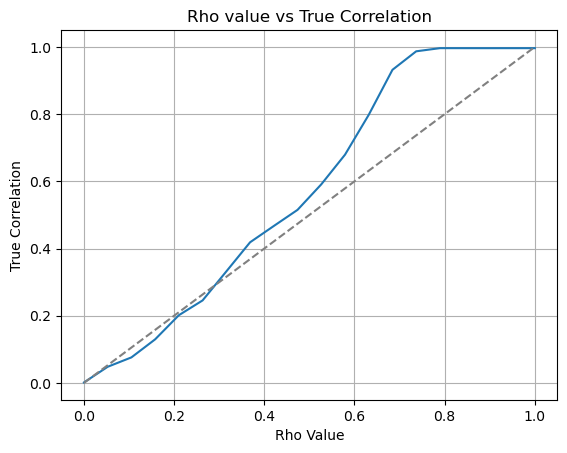

In [21]:
n = 50
lambda_ = 0.8
r = 2
branch_prob = 0.3
road_length = n//8
p = [0.1, 0.6, 0.3]
affluence_levels = {
    "rich": 1,
    "middle": 0.5,
    "poor": 0.1
}

# Assuming random_board is defined elsewhere and generates the matrices
rhos = np.linspace(0, 1, 20)
correlations = []
for rho in rhos:
    corr = 0
    for i in range(20):
        city_grid = generate_city_grid(n, branch_prob, road_length)
        affluence_grid, house_grid, political_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho)
        # Flatten matrices
        flat1 = affluence_grid.flatten()
        flat2 = political_grid.flatten()
        
        # Remove -1 values
        mask = (flat1 != -1) & (flat2 != -1)
        filtered_flat1 = flat1[mask]
        filtered_flat2 = flat2[mask]
        
        # Compute Pearson correlation
        if len(filtered_flat1) > 1:  # Ensure there are enough points for correlation
            corr += np.corrcoef(filtered_flat1, filtered_flat2)[0, 1]
    correlations.append(corr / 20)

# Plotting
plt.plot(rhos, correlations)
plt.xlabel('Rho Value')
plt.ylabel('True Correlation')
plt.title('Rho value vs True Correlation')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.grid(True)
plt.show()

In [22]:
# Initialize variables
n_iterations = 10
averaged_distribution = {}

# Run iterations to calculate the average distribution
for j in range(n_iterations):
    city_grid = generate_city_grid(n, branch_prob, road_length)
    affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho=0.3)
    
    # Flatten the matrix to a 1D array
    flattened_grid = politics_grid.flatten()

    # Filter out -1 values
    filtered_grid = flattened_grid[flattened_grid != -1]

    # Find unique values and their counts
    unique_values, counts = np.unique(filtered_grid, return_counts=True)

    # Calculate the probabilities based on the filtered grid
    probabilities = counts / filtered_grid.size

    # Combine values and probabilities into a dictionary and accumulate
    for value, prob in zip(unique_values, probabilities):
        if value in averaged_distribution:
            averaged_distribution[value].append(prob)
        else:
            averaged_distribution[value] = [prob]

# Now calculate the average for each value
for value in averaged_distribution:
    averaged_distribution[value] = np.mean(averaged_distribution[value])

# Print the average distribution
print("Average Probability Distribution of Political Opinion:")
for value, prob in sorted(averaged_distribution.items()):
    print(f"Value {value}: {prob:.2%}")


Average Probability Distribution of Political Opinion:
Value 0.0: 29.05%
Value 0.5: 46.74%
Value 1.0: 24.21%


In [5]:
def calculate_neighborhood_average(grid, x, y, r):
    """
    Calculate the average grid value in the square neighborhood of radius r around (x, y).
    """
    n, m = grid.shape
    weighted_sum = 0
    total_weight = 0
    x_min, y_min = max(0,x-r), max(0,y-r)
    x_max, y_max = min(n-1,x+r), min(m-1,y+r)

    # Iterate over the neighborhood within the radius
    for i in range(x_min, x_max+1):
        for j in range(y_min, y_max+1):
            if grid[i, j] >= 0:
                dx, dy = x - i, y - j
                distance_squared = dx**2 + dy**2
                # Exclude self from nbhd avg
                if distance_squared == 0:
                    weight = 0
                else:
                    weight = 1 / distance_squared
                weighted_sum += house_grid[i, j] * weight
                total_weight += weight

    # Check if total_weight is zero to avoid division by zero
    if total_weight == 0:
        return 0
    # Calculate the weighted average of the neighborhood
    weighted_average = weighted_sum / total_weight
    return weighted_average

In [7]:
def calculate_ethnicity_average(ethnicity_grid, x, y, target_ethnicity, r):
    """Calculate the proportion of agents around the point x,y (square radius r) that have the target ethnicity.

    Args:
        ethnicity_grid (np.ndarray): 
        x (int): x-coordinate of house I may move to
        y (int): y-coordinate of house I may move to
        target_ethnicity (int): The ethnicity I'm trying to calculate a proportion for
        r (int): Neighbourhood radius

    Returns:
        float: Proportion with target ethnicity
    """
    # instantly jump out if I've been fed an empty space (road)
    if ethnicity_grid[x, y] == -1:
        return 0

    n, m = ethnicity_grid.shape
    x_min, y_min = max(0,x-r), max(0,y-r)
    x_max, y_max = min(n-1,x+r), min(m-1,y+r)
    count = 0
    total = 0

    # Go through neighbourhood and count number of occupied houses and how many are of the target ethnicity
    for i in range(x_min, x_max+1):
        for j in range(y_min, y_max+1):
            # don't include the house itself in the proportion, because we're either living there (so we don't include ourselves)
            # or we want to move there, in which case we'd be swapping with (x,y) so it shouldn't be included in the count
            if i == x and j == y:
                continue

            if ethnicity_grid[i,j] != -1:
                total += 1
                if ethnicity_grid[i,j] == target_ethnicity:
                    count += 1

    if total == 0:
        return 0
    else:
        return count / total

In [13]:
def calculate_ethnic_delta(ethnicity_grid: np.ndarray, x1: int, y1: int, x2: int, y2: int, r) -> float:
    """Calculate ethnicity delta of the two points (x1,y1), (x2,y2).

    Args:
        ethnicity_grid (np.ndarray): 
        x1 (int): 
        y1 (int): 
        x2 (int): 
        y2 (int): 

    Returns:
        float: The ethnicity delta
    """
    # proportions matching ethnicity in current locations
    p1_current_eth_prop = calculate_ethnicity_average(ethnicity_grid, x1, y1, ethnicity_grid[x1,y1], r)
    p2_current_eth_prop = calculate_ethnicity_average(ethnicity_grid, x2, y2, ethnicity_grid[x2,y2], r)

    # proportions matching ethnicity if they were to swap
    p1_swapped_eth_prop = calculate_ethnicity_average(ethnicity_grid, x2, y2, ethnicity_grid[x1,y1], r)
    p2_swapped_eth_prop = calculate_ethnicity_average(ethnicity_grid, x1, y1, ethnicity_grid[x2,y2], r)

    # this will be positive if swapping would increase the matching ethnic proportion for both agents
    # (or e.g. increases lots for one agent decreases a bit for the other)
    delta_eth = (p1_swapped_eth_prop - p1_current_eth_prop) + (p2_swapped_eth_prop - p2_current_eth_prop)

    return delta_eth

In [15]:
def calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_):
    """Calculates new house values using a convolution.

    Args:
        house_grid (np.ndarray): House price grid V
        affluence_grid (np.ndarray): Affluence grid A
        r (int): Neighbourhood radius
        lambda_ (float): Modeling parameter
        calc_num_neighbours (bool, optional): Whether to calculate number of neighbours or to just use kernel size. When the 
        grid is full (as in the toy model), we can set this to false as there are always the same number of neighbours. Defaults to False.

    Returns:
        np.ndarray: The new house values
    """
    # Split into 1 for has house there and 0 for doesn't
    house_grid_binary = np.copy(house_grid)
    house_grid_binary = np.where(house_grid_binary == -1, 0, 1)

    # Reset empty grid points (roads etc) to 0 to aid calculation
    house_grid_zeroed = np.copy(house_grid)
    house_grid_zeroed = np.where(house_grid_zeroed == -1, 0, house_grid_zeroed)

    # I think we include the house itself in the nbhd calculation?
    kernel = np.ones((2*r+1, 2*r+1))    

    count = scipy.signal.convolve2d(house_grid_binary, kernel, mode='same', boundary="symm")

    # Updated house prices. idk if symmetric bdary conditions is the right thing to do
    nbhd_average = scipy.signal.convolve2d(house_grid_zeroed, kernel, mode='same', boundary="symm") / count
    V_tplus1 = affluence_grid + lambda_*nbhd_average
    V_tplus1 = np.where(house_grid == -1, -1, V_tplus1) # make sure to keep gaps from before

    return V_tplus1

In [17]:
def propose_swap(affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid, r):
    """
    Calculate delta and swap agents if delta > 0.
    """
    pol_weight = 1/3
    rel_weight = 1/3
    eth_weight = 1/3
    n, m = house_grid.shape
    
    # Choose two random houses
    x1, y1 = random.randint(0, n-1), random.randint(0, m-1)
    x2, y2 = random.randint(0, n-1), random.randint(0, m-1)

    if house_grid[x1, y1] == -1 or house_grid[x2, y2] == -1:
        return 0

    else:
        A_x1, V_x1 = affluence_grid[x1, y1], house_grid[x1, y1] / np.max(house_grid)
        A_x2, V_x2 = affluence_grid[x2, y2], house_grid[x2, y2] / np.max(house_grid)
        delta_econ = (A_x1 - V_x1)**2 + (A_x2 - V_x2)**2 - (A_x1 - V_x2)**2 - (A_x2 - V_x1)**2
        
        P_x1, P_x2 = politics_grid[x1, y1], politics_grid[x2, y2]
        P_nbhd_x1, P_nbhd_x2 = calculate_neighborhood_average(politics_grid, x1, y1, r), calculate_neighborhood_average(politics_grid, x2, y2, r)
        delta_pol = (P_x1 - P_nbhd_x1)**2 + (P_x2 - P_nbhd_x2)**2 - (P_x1 - P_nbhd_x2)**2 - (P_x2 - P_nbhd_x1)**2 
    
        R_x1, R_x2 = religion_grid[x1, y1], religion_grid[x2, y2]
        R_nbhd_x1, R_nbhd_x2 = calculate_neighborhood_average(religion_grid, x1, y1, r), calculate_neighborhood_average(religion_grid, x2, y2, r)
        delta_rel = (R_x1 - R_nbhd_x1)**2 + (R_x2 - R_nbhd_x2)**2 - (R_x1 - R_nbhd_x2)**2 - (R_x2 - R_nbhd_x1)**2
    
        delta_eth = calculate_ethnic_delta(ethnicity_grid, x1, y1, x2, y2, r)
        
        if delta_econ + rel_weight * delta_rel + pol_weight * delta_pol + eth_weight * delta_eth > 0:
            # Swap the two agents on all grids
            affluence_grid[x1, y1], affluence_grid[x2, y2] = A_x2, A_x1
            politics_grid[x1, y1], politics_grid[x2, y2] = P_x2, P_x1
            religion_grid[x1, y1], religion_grid[x2, y2] = R_x2, R_x1
            ethnicity_grid[x1, y1], ethnicity_grid[x2, y2] = ethnicity_grid[x2, y2], ethnicity_grid[x1, y1]
            return 1
        else:
            return 0

In [93]:
n = 50
lambda_ = 0.85
r = 2
rho = 0.1
branch_prob = 0.3
road_length = n//8
p = [0.1, 0.6, 0.3]
affluence_levels = {
    "rich": 1,
    "middle": 0.5,
    "poor": 0.1
}
city_grid = generate_city_grid(n, branch_prob, road_length)

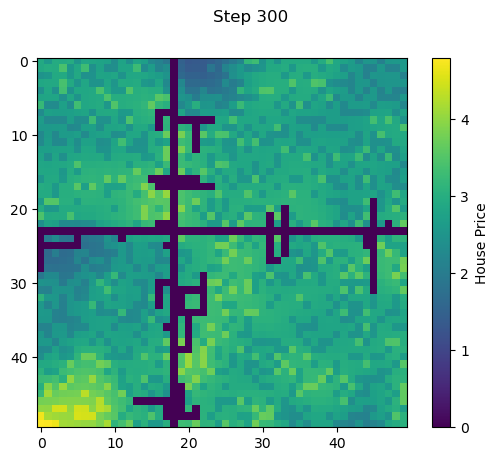

In [95]:
# Simulation parameters
n_steps = 300
affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho)

fig, ax = plt.subplots()
fig.suptitle('Step 0')
img = plt.imshow(house_grid, cmap='viridis',vmin=0, vmax=1)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label('House Price')

rich_indices = affluence_grid == 1.0
poor_indices = affluence_grid == 0.1
non_road_indices = house_grid != -1

rich_house_prices = house_grid[rich_indices]
poor_house_prices = house_grid[poor_indices]
all_house_prices = house_grid[non_road_indices]

avg_rich_prices = [rich_house_prices.mean()]
avg_poor_prices = [poor_house_prices.mean()]
avg_prices = [all_house_prices.mean()]

# Simulation loop
for step in range(n_steps+1):
    # Update house values
    #house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)
    house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)
    
    # Propose random move - several in each step
    i = 0
    while i < 25:
        i += propose_swap(affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid, r)
        
    rich_indices = affluence_grid == 1.0
    poor_indices = affluence_grid == 0.1
    
    rich_house_prices = house_grid[rich_indices]
    poor_house_prices = house_grid[poor_indices]
    all_house_prices = house_grid[non_road_indices]

    avg_rich_prices.append(rich_house_prices.mean())
    avg_poor_prices.append(poor_house_prices.mean())
    avg_prices.append(all_house_prices.mean())
    
    img.set_array(house_grid)
    img.set_clim(vmax = np.max(house_grid))
    fig.suptitle(f"Step {step}")
    if step % 20 == 0:
        plt.pause(0.01)
        clear_output(wait=True)
        display(fig)

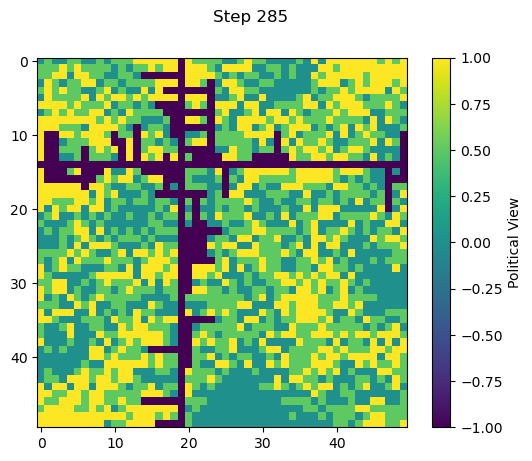

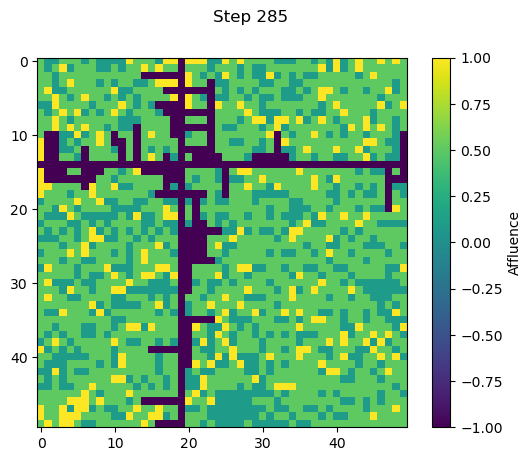

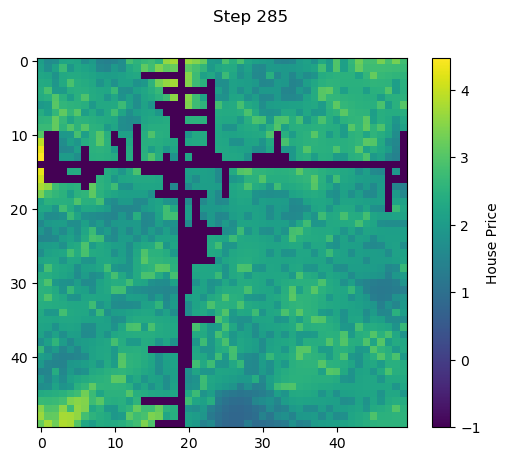

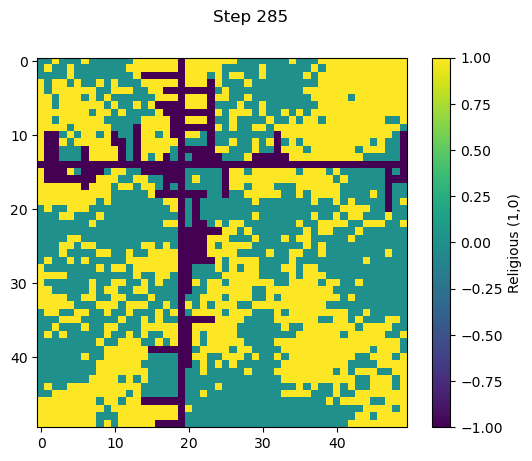

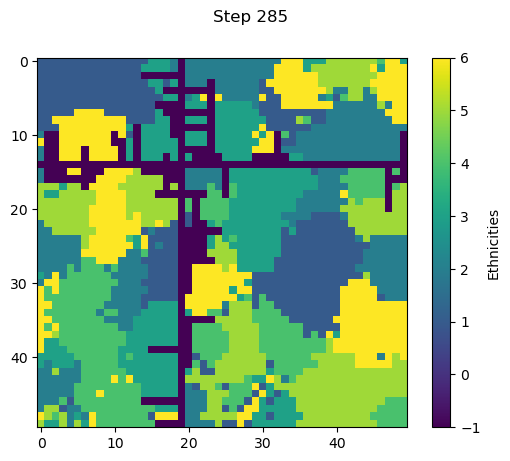

In [187]:
img.set_array(politics_grid)
img.set_clim(vmin = -1, vmax = np.max(politics_grid))
cbar.set_label('Political View')
display(fig)
img.set_array(affluence_grid)
img.set_clim(vmin = np.min(affluence_grid), vmax = np.max(affluence_grid))
cbar.set_label('Affluence')
display(fig)
img.set_array(house_grid)
img.set_clim(vmax = np.max(house_grid))
cbar.set_label('House Price')
display(fig)
img.set_array(religion_grid)
img.set_clim(vmin = -1, vmax = np.max(religion_grid))
cbar.set_label('Religious (1,0)')
display(fig)
img.set_array(ethnicity_grid)
img.set_clim(vmin =-1, vmax = np.max(ethnicity_grid))
cbar.set_label('Ethnicities')
display(fig)

#### Average House Prices

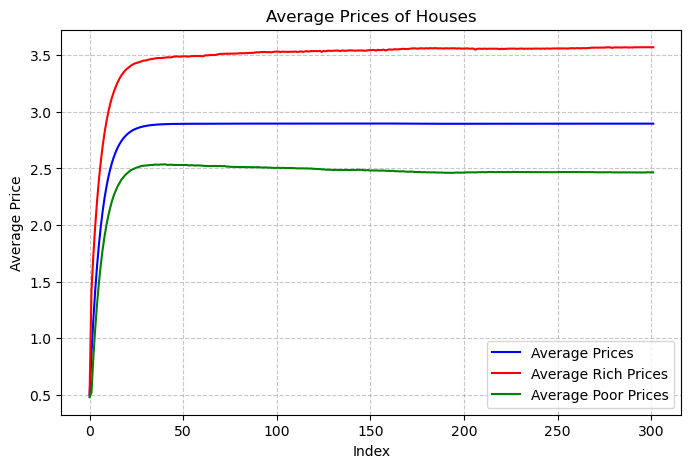

In [91]:
# House prices over time
# Create indices for the averages
indices = list(range(len(avg_prices)))

# Plot the averages against their indices
plt.figure(figsize=(8, 5))
plt.plot(indices, avg_prices, linestyle='-', color='b', label="Average Prices")
plt.plot(indices, avg_rich_prices, linestyle='-', color='r', label="Average Rich Prices")
plt.plot(indices, avg_poor_prices, linestyle='-', color='g', label="Average Poor Prices")
plt.title("Average Prices of Houses")
plt.xlabel("Index")
plt.ylabel("Average Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Simulating for lambda = 0.10...
Simulating for lambda = 0.15...
Simulating for lambda = 0.19...
Simulating for lambda = 0.24...
Simulating for lambda = 0.29...
Simulating for lambda = 0.34...
Simulating for lambda = 0.38...
Simulating for lambda = 0.43...
Simulating for lambda = 0.48...
Simulating for lambda = 0.53...
Simulating for lambda = 0.57...
Simulating for lambda = 0.62...
Simulating for lambda = 0.67...
Simulating for lambda = 0.72...
Simulating for lambda = 0.76...
Simulating for lambda = 0.81...
Simulating for lambda = 0.86...
Simulating for lambda = 0.91...
Simulating for lambda = 0.95...
Simulating for lambda = 1.00...


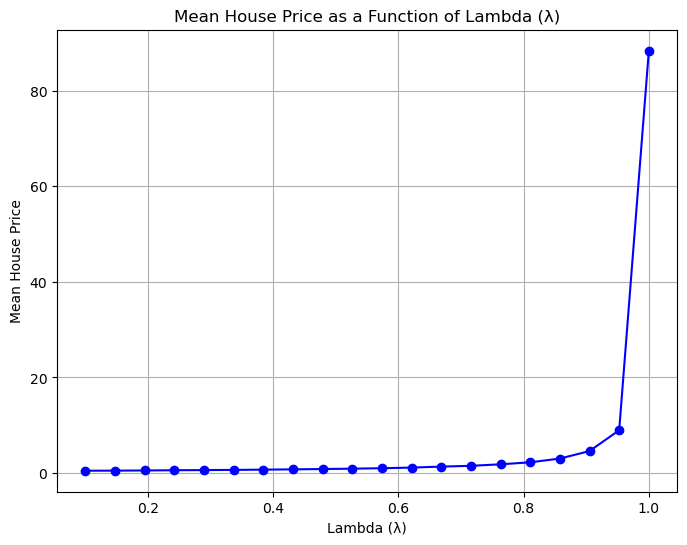

In [151]:
# Mean house price as a function of lambda 
# Simulation parameters
n_steps = 200
lambda_values = np.linspace(0.5, 0.95, 10)  # Range of lambda values to test
mean_prices = []  # To store the mean house price for each lambda

for lambda_ in lambda_values:
    print(f"Simulating for lambda = {lambda_:.2f}...")
    
    # Initialize the grids for each simulation
    affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(
        city_grid, affluence_levels, p, rho
    )

    for step in range(n_steps + 1):
        # Update house values
        house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)

        # Propose random moves
        i = 0
        while i < 25:
            i += propose_swap(affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid, r)

    # Calculate the mean house price at the end of the simulation
    non_road_indices = house_grid != -1
    all_house_prices = house_grid[non_road_indices]
    mean_prices.append(all_house_prices.mean())

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, mean_prices, marker='o', color='b')
plt.xlabel("Lambda (λ)")
plt.ylabel("Mean House Price")
plt.title("Mean House Price as a Function of Lambda (λ)")
plt.grid(True)
plt.show()

## Segregation Index

In [87]:
def spatial_segregation(U):
    m, n = U.shape
    assert m == n, "U (the matrix, not you) must be square" # We could maybe generalise to m != n? But then we'd have to compute our own expected_entropy.

    # Get eigenvals of covariance matrix and apply a normalisation
    Q = U.T @ U # we assume U is real so just use the regular transpose
    eigenvals, _ = np.linalg.eig(Q)
    # keep only real parts (evals should be real but sometimes np accidentally gives a tiny imaginary component).
    # sort eigenvals from largest abs value to smallest, then keep only those that are non zero
    eigenvals = np.array(sorted(np.real(eigenvals), key = abs, reverse = True))
    eigenvals = eigenvals[np.abs(eigenvals) > 1e-5] # get rid of eigenvalues that are basically 0
    p_i_denom = sum(np.abs(eigenvals[1:]))
    p = eigenvals / p_i_denom

    # Measure the entropy and subtract from the expected entropy to get the segregation measure
    H_BO = -sum(p[1:] * np.log(p[1:]))
    expected_entropy = np.log(3/5 * n) # this is given in the text. Although they don't specify natural log, this is closest to actual results
    S_BO = expected_entropy - H_BO

    return S_BO

def theil_index(props):
    """Get the theil index (a measure of inequality) of a vector of n proportions

    Args:
        props (np.ndarray): Proportions (must sum to around 1)

    Returns:
        float: Theil index of given distribution
    """
    assert all(props >= 0), "Proportions should all be non-negative"
    assert np.abs(np.sum(props) - 1) < 1e-5, "Proportions should sum to 1 (modulo some rounding errors)"
    return np.log(len(props)) + np.sum(props * np.log(props))

def generate_unequal_props(eta: float):
    """Generate a vector of 3 proportions using the 1 parameter family 5.1 from Aguilera et al 2007. You can
    then multiply these proportions by your total number of agents to get the desired number of agents in each group.

    Args:
        eta (float): A parameter between 0.5 and 1 (exclusive), used to generate the proportions. A higher eta corresponds to a higher Theil index.

    Returns:
        props: A 3d vector of proportions, proportion poor, middle, and rich (in that order).
        ti: The Theil index corresponding to the above vector
    """
    assert 0.5 < eta < 1, "Eta must be between 0.5 and 1 (exclusive)"

    a = 0.4 # this is the fixed value used throughout section 5 of Aguilera
    props = np.array([eta, (1-a)*(1-eta), a*(1-eta)])
    ti = theil_index(props)

    return props, ti

#### Segregation over time

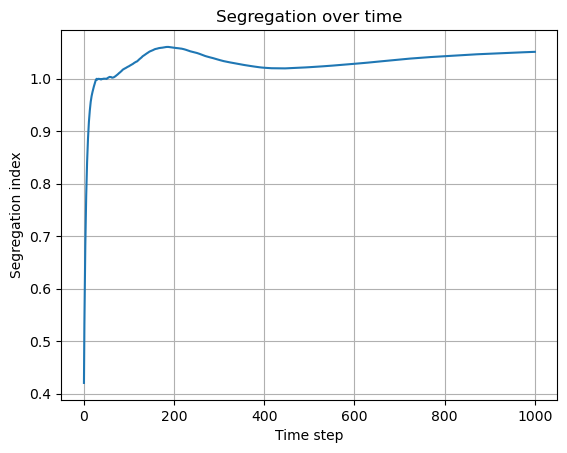

In [162]:
# Simulation parameters
n_steps = 1000
city_grid = generate_city_grid(n, branch_prob, road_length)
affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho)
seg_indices=[]

# Simulation loop
for step in range(n_steps+1):
    # Update house values
    house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)

    # Propose random move - several in each step
    i = 0
    while i < 25:
        i += propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, ethnicity_grid, r)
        
    seg_ind = spatial_segregation(house_grid)
    seg_indices.append(seg_ind)

indices = list(range(len(seg_indices)))
plt.plot(indices, seg_indices)
plt.xlabel('Time step')
plt.ylabel('Segregation index')
plt.title('Segregation over time')
plt.grid(True)
plt.show()

#### If n_steps * swap_nr = constant

C:\Users\kinga\AppData\Local\Temp\ipykernel_136220\2823386472.py:29: RuntimeWarning: invalid value encountered in divide
  nbhd_average = scipy.signal.convolve2d(house_grid_zeroed, kernel, mode='same', boundary="symm") / count


n_steps: 100, swap_nr: 50, Avg Segregation Index: 1.2001
n_steps: 200, swap_nr: 25, Avg Segregation Index: 1.2236
n_steps: 250, swap_nr: 20, Avg Segregation Index: 1.1871
n_steps: 500, swap_nr: 10, Avg Segregation Index: 1.2322


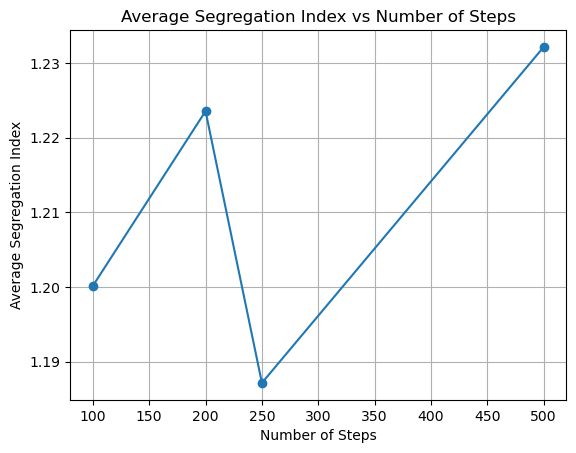

In [159]:
total_swaps = 5000
# Test different combinations of n_steps and swap_nr
combinations = [(100, total_swaps // 100),
                (200, total_swaps // 200),
                (250, total_swaps // 250), 
                (500, total_swaps // 500)]

average_segregation_indices = []

# Iterate over different combinations
for n_steps, swap_nr in combinations:
    seg_indices = []

    for j in range(10):  # Repeat experiment 10 times for averaging
        # Initialize random board
        city_grid = generate_city_grid(n, branch_prob, road_length)
        affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho)

        # Simulation loop
        for step in range(n_steps + 1):
            # Update house values
            house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)
            
            # Propose random moves (swap_nr times per step)
            i = 0
            while i < swap_nr:
                i += propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, ethnicity_grid, r)
        
        # Compute segregation index
        seg_ind = spatial_segregation(house_grid)
        seg_indices.append(seg_ind)
    
    # Compute average segregation index for this combination
    avg_seg_ind = np.mean(seg_indices)
    average_segregation_indices.append(avg_seg_ind)
    print(f"n_steps: {n_steps}, swap_nr: {swap_nr}, Avg Segregation Index: {avg_seg_ind:.4f}")

#### Segregation over time + error bars (std)

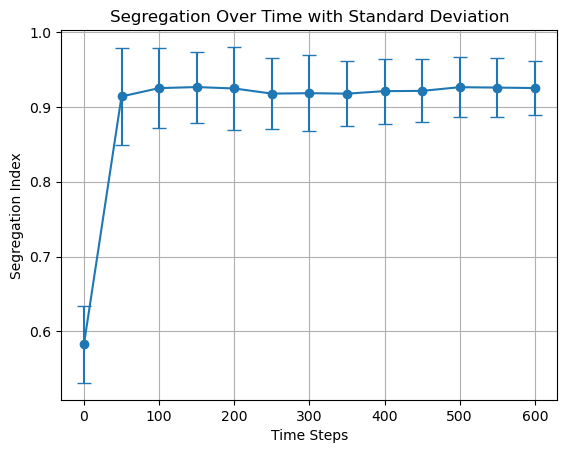

In [89]:
# Simulation parameters
n_steps = 600
step_interval = 50  # Record segregation index every 100 steps
n_time_points = n_steps // step_interval + 1
n_experiments = 5

seg_indices = np.zeros((n_experiments, n_time_points))

for j in range(n_experiments):
    # Initialize random board
    city_grid = generate_city_grid(n, branch_prob, road_length)
    affluence_grid, house_grid, politics_grid, religion_grid, ethnicity_grid = initialize_affluence_and_house_grids(city_grid, affluence_levels, p, rho)
    
    # Simulation loop
    for step in range(n_steps + 1):
        # Update house values
        house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)
        
        # Propose random swaps
        i = 0
        while i < 25:
            i += propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, ethnicity_grid, r)
        
        # Record segregation index every 100 steps
        if step % step_interval == 0:
            seg_ind = spatial_segregation(house_grid)
            seg_indices[j][step // step_interval] = seg_ind

# Calculate mean and standard deviation of segregation indices
mean_seg = np.mean(seg_indices, axis=0)
std_seg = np.std(seg_indices, axis=0)

# Time points corresponding to recorded steps
time_points = np.arange(0, n_steps + 1, step_interval)

# Plotting with error bars
plt.errorbar(time_points, mean_seg, yerr=std_seg, fmt='-o', capsize=5)
plt.xlabel('Time Steps')
plt.ylabel('Segregation Index')
plt.title('Segregation Over Time with Standard Deviation')
plt.grid(True)
plt.show()